In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import PIL
import os 
import matplotlib.pyplot as plt
import sklearn
import transformers
from transformers import pipeline
from imblearn.over_sampling import(RandomOverSampler)
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sklearn.model_selection import KFold

In [45]:
# The data set is found here on Kaggle: 
# https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

from PIL import Image
testImage = Image.open('Desktop/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')

# I print out one of the images to see what the size of the image is in pixels and its qualities

In [46]:
print(testImage.format)
print(testImage.size)
print(testImage.mode)

JPEG
(176, 208)
L


In [47]:
# I print out what the test image looks like as an array, as I plan to convert all the test images into arrays.

testArray = np.asarray(testImage)

np.set_printoptions(threshold=np.inf)

print(testArray)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0

In [48]:
# This for loop takes every image in the Alzheimer's Dataset file (which is already separated into test and 
# training sets) and puts it into X_train and X_test lists (I use lists rather than arrays because it is easier to
# iterate to add items to a list, and then convert to arrays later). Meanwhile, according to which stage of 
# Alzheimer's it is, I put the stage in the Y_train or Y_test list, turning the stages into integers in order of
# severity so they can be used in a regression, which I plan to use even though this is a classification problem
# to account for how the class numbers are not arbitrary but in order of severity.

X_train = []
X_test = []
Y_train = []
Y_test = []

for testTrain in os.listdir('Desktop/Alzheimer_s Dataset'):
    if testTrain != '.DS_Store':
        for dementia in os.listdir('Desktop/Alzheimer_s Dataset/' + testTrain):
            if dementia != '.DS_Store':
                for file in os.listdir('Desktop/Alzheimer_s Dataset/' + testTrain + '/' + dementia):
                    if testTrain == 'train':
                        img = Image.open('Desktop/Alzheimer_s Dataset/' + testTrain + '/' + dementia + '/' + file)
                        X_train.append(np.asarray(img))
                        if dementia == 'MildDemented':
                            Y_train.append(3.0)
                        elif dementia == 'ModerateDemented':
                            Y_train.append(4.0)
                        elif dementia == 'NonDemented':
                            Y_train.append(1.0)
                        elif dementia == 'VeryMildDemented':
                            Y_train.append(2.0)

                    elif testTrain == 'test':
                        img = Image.open('Desktop/Alzheimer_s Dataset/' + testTrain + '/' + dementia + '/' + file)
                        X_test.append(np.asarray(img))
                        if dementia == 'MildDemented':
                            Y_test.append(3.0)
                        elif dementia == 'ModerateDemented':
                            Y_test.append(4.0)
                        elif dementia == 'NonDemented':
                            Y_test.append(1.0)
                        elif dementia == 'VeryMildDemented':
                            Y_test.append(2.0)


In [49]:
# Here I check my data set, seeing the length of the training and test sets. 

print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

print(Y_train.count(1.0))
print(Y_train.count(2.0))
print(Y_train.count(3.0))
print(Y_train.count(4.0))

print(Y_test.count(1.0))
print(Y_test.count(2.0))
print(Y_test.count(3.0))
print(Y_test.count(4.0))

# The more severe the dementia is, the fewer images there are representing it, meaning that stratified partition
# would be preferable over random partition when creeating validation folds if I don't undersample/oversample and I 
# should either use a loss function that weights the less common classes more heavily, undersample (not ideal
# because there are VERY few of the rarest class) or oversample.


5121
5121
1279
1279
2560
1792
717
52
640
448
179
12


In [50]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print('X_train is ' + str(X_train.shape))
print('X_test is ' + str(X_test.shape))

X_train is (5121, 208, 176)
X_test is (1279, 208, 176)


In [51]:
# I flatten the arrays because arrays must be flattened to be oversampled with imblearn, and it is also helpful
# for making the data into a dataset that I can do Exploratory Data Analysis on. See below for why I flatten the 
# test data even though I am not doing analysis on it and you don't want to oversample test data.

X_trainFlat = X_train.reshape((5121, 36608))
X_testFlat = X_test.reshape((1279, 36608))


print('X_train is now ' + str(X_trainFlat.shape))
print('X_test is now ' + str(X_testFlat.shape))

X_train is now (5121, 36608)
X_test is now (1279, 36608)


In [9]:
X_trainDF = pd.DataFrame(X_trainFlat)
X_trainDF.head

<bound method NDFrame.head of       0      1      2      3      4      5      6      7      8      9      \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      0      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5116      0      0      0      0      0      0      0      0      0      0   
5117      0      0      0      0      0      0      0      0      0      0   
5118      0      0      0      0      0      0      0      0      0      0   
5119      0      0      0      0      0      0      0      0      0      0   
5120      0      0      0      0      0      0      0      0      0      0   

      ...  36598  36599  36600  3

In [10]:
#pd.set_option('display.max_columns', 10000)
X_trainDF.describe()

,0,1,2,3,4,5,6,7,8,9,...,36598,36599,36600,36601,36602,36603,36604,36605,36606,36607
count,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,...,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0,5121.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


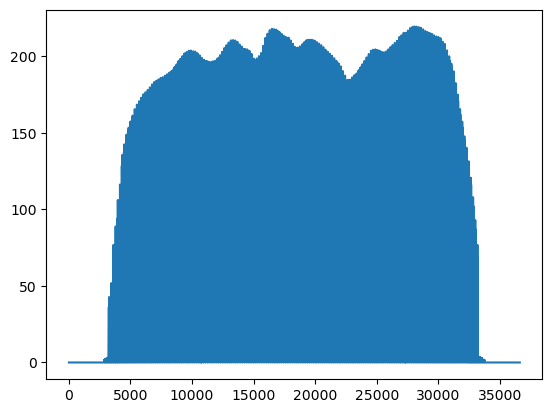

In [11]:
# A graph of how the average value of a pixel in the image changes over row and column.

plt.plot(X_trainDF.columns, X_trainDF.describe().loc['mean'])

In [55]:
# I chose to oversample because, as I said, undersampling would leave me with too little data, and it would be hard
# to find a loss function that accounts for rarer classes while also accomplishing other things I want like 
# acknowledging the classes are ordinal. I oversample every class besides the majority class. This also means I 
# don't have to do a stratified K-fold. I don't oversample the test set because, while I need to train the model
# on more of the rarer classes, the test set is for seeing how it performs on a data set just like the real world.

over = RandomOverSampler(sampling_strategy = 'not majority', random_state = 100)
X_trainOver, Y_trainOver = over.fit_resample(X_trainFlat, Y_train)

# this last part is not actually going to be used for the final results, since the idea is to see how the model 
# performs on the actual imbalanced data you will see (so the test set should not be oversampled), this is just
# a test I added later on to see if underperformance on the test set as opposed to the kFolds of the training set
# was caused by normal overfit or a result of class imbalance leading to overpredicting more severe stages being
# more likely. Since there isn't an option to resample the test data 
# without fitting (since oversample isn't designed to be used for test data), I tried two variants, one where the 
# original oversampler with another fit was used and one where a second oversampler was created.

X_testOver, Y_testOver = over.fit_resample(X_testFlat, Y_test)

over2 = RandomOverSampler(sampling_strategy = 'not majority', random_state = 103)
X_testOver2, Y_testOver2 = over2.fit_resample(X_testFlat, Y_test)

X_testOver is (2560, 36608)


In [56]:
# This is successful, in the training set each class is now equally common.

print('X_trainOver is' + str(X_trainOver.shape))
print('X_testOver is ' + str(X_testOver.shape))

Y_trainList = np.ndarray.tolist(Y_trainOver)

print(Y_trainList.count(1.0))
print(Y_trainList.count(2.0))
print(Y_trainList.count(3.0))
print(Y_trainList.count(4.0))

X_trainOver is(10240, 36608)
X_testOver is (2560, 36608)
2560
2560
2560
2560


In [57]:
X_trainOver = X_trainOver/255.0
X_test = X_test/255.0
X_testOver = X_testOver/255.0
X_testOver2 = X_testOver2/255.0

In [58]:
# made two X_trainOvers, X_trainOver2 is for immediate use in my neural network from scratch, having one color 
# channel to be compatible with that neural network, while X_trainOver is intended for use in the resNet neural 
# network, to be eventually changed to have three color channels that are all copies of each other because that is
# necessary to be compatible with resNet.

X_trainOver = X_trainOver.reshape(10240, 208, 176)
X_trainOver2 = X_trainOver.reshape(10240, 208, 176, 1)

X_test = X_test.reshape(1279, 208, 176, 1)
X_testOver = X_testOver.reshape(2560, 208, 176, 1)
X_testOver2 = X_testOver2.reshape(2560, 208, 176, 1)

print('X_trainOver2 is' + str(X_trainOver2.shape))
print('X_test is' + str(X_test.shape))
print('X_testOver is' + str(X_testOver.shape))
print('X_testOver2 is' + str(X_testOver2.shape))

X_trainOver2 is(10240, 208, 176, 1)
X_test is(1279, 208, 176, 1)
X_testOver is(2560, 208, 176, 1)
X_testOver2 is(2560, 208, 176, 1)


In [27]:
# I use mean squared error over mean absolute error here (as both the loss and metric) because in cases like 
# diagnosing Alzheimer's I think it's especially important to avoid large errors, like mistaking someone with no
# Alzheimer's at all for having moderate Alzheimer's.

# I resize the data, dividing the height and width by 4, because the large images would mean so many variables that
# the neural network would run extremely slowly.

# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

fold_no = 1

for train, valid in folds.split(X_trainOver, Y_trainOver):
    alzCNN = tf.keras.Sequential()
    
    alzCNN.add(tf.keras.layers.Resizing(height = 52, width = 44))

    alzCNN.add(tf.keras.layers.Conv2D(filters=6,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 input_shape=(52, 44, 1)))

    alzCNN.add(tf.keras.layers.Conv2D(filters=12,
                                 kernel_size=(3, 3),
                                 activation='relu'))
    
    alzCNN.add(tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(5, 5),
                                 activation='relu'))

    alzCNN.add(tf.keras.layers.AveragePooling2D())

    alzCNN.add(tf.keras.layers.Flatten())

    alzCNN.add(tf.keras.layers.Dense(units=40,
                       activation='relu'))
    alzCNN.add(tf.keras.layers.Dense(units=20,
                       activation='relu'))
    alzCNN.add(tf.keras.layers.Dense(units=1,
                       activation='linear'))
    
    alzCNN.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    alzCNN.fit(X_trainOver2[train], Y_trainOver[train],
              batch_size=256,
              epochs=50,
              verbose=2,)
    
    score = alzCNN.evaluate(X_trainOver2[valid], Y_trainOver[valid], verbose=0)
    print(f'Score for fold {fold_no}: mse of {score}')
        
    fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
32/32 - 3s - loss: 2.2519 - mse: 2.2519 - 3s/epoch - 101ms/step
Epoch 2/50
32/32 - 3s - loss: 1.3705 - mse: 1.3705 - 3s/epoch - 92ms/step
Epoch 3/50
32/32 - 3s - loss: 1.2921 - mse: 1.2921 - 3s/epoch - 95ms/step
Epoch 4/50
32/32 - 3s - loss: 1.2009 - mse: 1.2009 - 3s/epoch - 105ms/step
Epoch 5/50
32/32 - 4s - loss: 1.0688 - mse: 1.0688 - 4s/epoch - 111ms/step
Epoch 6/50
32/32 - 4s - loss: 0.9125 - mse: 0.9125 - 4s/epoch - 116ms/step
Epoch 7/50
32/32 - 4s - loss: 0.7457 - mse: 0.7457 - 4s/epoch - 114ms/step
Epoch 8/50
32/32 - 4s - loss: 0.6011 - mse: 0.6011 - 4s/epoch - 131ms/step
Epoch 9/50
32/32 - 4s - loss: 0.5132 - mse: 0.5132 - 4s/epoch - 116ms/step
Epoch 10/50
32/32 - 4s - loss: 0.4584 - mse: 0.4584 - 4s/epoch - 133ms/step
Epoch 11/50
32/32 - 4s - loss: 0.4306 - mse: 0.4306 - 4s/epoch - 114ms/step
Epoch 12/50
32/32 - 3s - loss: 0.4081 - mse: 0.4081 - 3s/epoch - 103ms/step
Ep

In [15]:
alzCNN.summary()

NameError: name 'alzCNN' is not defined

In [ ]:
np.var(Y_trainOver)

# In my initial attempts at a neural network, the MSE loss was about the same as the variance, meaning you could 
# get just as good results by always guessing the mean. I started out with four dense layers going from 120 to 80 
# to 20 to 1. Because I had so few images I reduced the number of dense layers, instead having three layers of 40, 
# 20 and 1. This did nothing to change the final MSE loss, which was between 1.26 and 1.28 for every fold. Raising
# the learning rate to 0.01, including with a schedule to lower it after the tenth epoch, made the loss drop
# far quicker, but after the tenth epoch or so, regardless of whether there was a schedule, the rate stopped
# dropping, staying at about 1.24. I tried doing a scheduled learning rate that started at 0.01 and then 
# exponentially decreased, which got the MSE loss down to 1.24 but no lower. I also tried an SGD learning rate and
# adding a third convolutional layer with 20 filters, none of them had any appreciable effect on the loss. This is
# likely because there aren't enough images in my data set to train a neural network from scratch.

# I then realized that I had accidentally made my second to last layer softmax instead of relu. Upon fixing this
# and running the learning rate schedule I had run before (with three convolutional layers of (3,3) kernel size, I 
# got unusual results; the first fold's loss went as low as 0.0196 on the 47th epoch, settling at 0.0335 at the 
# 50th, but every other fold remained stuck at around 1.24-1.25 or the same as the variance. This seemed to be 
# towards how lucky I was with the randomized parameters at the start of the training; on the first fold this number  
# was 3.89 but on later folds it varied from 14 to 209. However, this problem was fixed when I switched from the 
# custom schedule to constant learning rates. I also fixed the mistake that I had been looking at the training fold
# scores and not the evaluation using the validation fold.

# Here were my parameter search results for average evaluation score across the folds:

# adam, 3 convolution layers of all 3,3 kernel size, stride 1: 0.0765
# SGD, 3 convolution layers of all 3,3 kernel size, stride 1: 0.2787
# adamax, 3 convolution layers of all 3,3 kernel size, stride 1: 0.1807
# adam, 3 convolution layers of 3,3/3,3/5,5 kernel size, stride 1: 0.0569
# adam, 3 convolution layers of all 3,3 kernel size, stride 1 for first two layers and stride 2 for the last layer:
# 0.1422

# I also did tests for 3,3/5,5/7,7 or 3,3/5,5/7,7 layers with adam and stride 1, and four layers,
# however I accidentally did these while only looking at the training set loss and not on the evaluated score, 
# ignoring potential overfit. However,on all the tests I did do, lower training set loss always meant lower final 
# score, and I did not get better results than my 3,3/3,3/5,5 score in any of these, so I didn't repeat these tests.

In [64]:
# Here I make a version of X_trainOver with three color channels that are actually the same thing repeated three
# times - this is for compatibility with resNet, which requires three color channels.

X_trainOver3 = np.repeat(X_trainOver[..., np.newaxis], 3, -1)
print(X_trainOver3.shape) 

(10240, 208, 176, 3)


In [25]:
# Here I attempt transfer learning with resNet, which could correct the problem of me having very few images by 
# using another neural network with similar images, freezing the early layers, and using the final layers to 
# customize it for my particular data set. Unfortunately, while I managed to debug all the errors in this code,
# my computer doesn't seem to have the processing power to run such a large neural network and it crashes my kernel
# before getting into an epoch every time I tried. Since my "homemade" neural network still performed well above
# the variance, I accepted this, though I kept the code to show that I am capable of running ResNet (if I had more
# time I would have tried to figure out how to offload the processing onto something else, I tried to do this with
# google Colab but the code ran slower there than on Jupyter.

folds2 = KFold(n_splits = 5, shuffle = True, random_state = 102)

fold_no = 1

for train, valid in folds2.split(X_trainOver3, Y_trainOver):

    resModel = tf.keras.Sequential()
    

    pretrained_model = tf.keras.applications.ResNet101(
        include_top=False,
        weights= 'imagenet',
        input_tensor=None,
        input_shape=(52, 44, 3),
        pooling='avg')

    for layer in pretrained_model.layers:
        layer.trainable = False

    resModel.add(tf.keras.layers.Resizing(height = 52, width = 44))
    
    resModel.add(pretrained_model)
    
#     resModel.add(tf.keras.layers.Conv2D(filters=16,
#                                      kernel_size=(3, 3),
#                                      activation='relu'))
    
#     resModel.add(tf.keras.layers.AveragePooling2D())

    resModel.add(tf.keras.layers.Flatten())

#     resModel.add(tf.keras.layers.Dense(units=40,
#                        activation='relu'))
    resModel.add(tf.keras.layers.Dense(units=20,
                       activation='relu'))
    resModel.add(tf.keras.layers.Dense(units=1,
                       activation='linear'))

    resModel.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    resModel.fit(X_trainOver3[train], Y_trainOver[train],
              batch_size=256,
              epochs=50,
              verbose=2,)
        
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...


KeyboardInterrupt: 

In [30]:
#Final run through the test data:
    
alzCNN.fit(X_trainOver2, Y_trainOver,
            batch_size=256,
            epochs=50,
            verbose=2,)
    
score = alzCNN.evaluate(X_test, Y_test, verbose=0)
print(f'MSE = {score}')
        


Epoch 1/50
40/40 - 4s - loss: 0.1239 - mse: 0.1239 - 4s/epoch - 93ms/step
Epoch 2/50
40/40 - 4s - loss: 0.1267 - mse: 0.1267 - 4s/epoch - 107ms/step
Epoch 3/50
40/40 - 4s - loss: 0.1156 - mse: 0.1156 - 4s/epoch - 111ms/step
Epoch 4/50
40/40 - 5s - loss: 0.1176 - mse: 0.1176 - 5s/epoch - 123ms/step
Epoch 5/50
40/40 - 4s - loss: 0.1152 - mse: 0.1152 - 4s/epoch - 104ms/step
Epoch 6/50
40/40 - 4s - loss: 0.1085 - mse: 0.1085 - 4s/epoch - 105ms/step
Epoch 7/50
40/40 - 4s - loss: 0.1029 - mse: 0.1029 - 4s/epoch - 106ms/step
Epoch 8/50
40/40 - 4s - loss: 0.1138 - mse: 0.1138 - 4s/epoch - 110ms/step
Epoch 9/50
40/40 - 4s - loss: 0.1033 - mse: 0.1033 - 4s/epoch - 100ms/step
Epoch 10/50
40/40 - 4s - loss: 0.0985 - mse: 0.0985 - 4s/epoch - 97ms/step
Epoch 11/50
40/40 - 4s - loss: 0.0934 - mse: 0.0934 - 4s/epoch - 92ms/step
Epoch 12/50
40/40 - 4s - loss: 0.0907 - mse: 0.0907 - 4s/epoch - 93ms/step
Epoch 13/50
40/40 - 4s - loss: 0.0930 - mse: 0.0930 - 4s/epoch - 96ms/step
Epoch 14/50
40/40 - 4s - l

Although the loss rent down to 0.0269 at the end, the final MSE ended up being 0.679. It seems odd that there would be this much of an overfitting problem when I used kFold, so I wondered if this was because of using oversampling on the training data but not on the test data. I thus decided, as a test (not my final result, since the goal is to see how well you can perform on the actual data) to create a version of X_test and Y_test with oversampling and see if the model performs better when evaluated based on that. 

I also noticed that since I already had trained this neural network on the kFolds, it started out with a much lower
loss than it did when I started training on the kFold. I think this could be a cause of overfit, so I also tried to run a different, identical neural network that had not been trained, so I was getting an actual 50 epochs instead of an effective 100, so I would not overfit. 

In [42]:

alzCNN2 = tf.keras.Sequential()
    
alzCNN2.add(tf.keras.layers.Resizing(height = 52, width = 44))

alzCNN2.add(tf.keras.layers.Conv2D(filters=6,
                                kernel_size=(3, 3),
                                activation='relu',
                                input_shape=(52, 44, 1)))

alzCNN2.add(tf.keras.layers.Conv2D(filters=12,
                                kernel_size=(3, 3),
                                activation='relu'))
    
alzCNN2.add(tf.keras.layers.Conv2D(filters=16,
                                kernel_size=(5, 5),
                                activation='relu'))

alzCNN2.add(tf.keras.layers.AveragePooling2D())

alzCNN2.add(tf.keras.layers.Flatten())

alzCNN2.add(tf.keras.layers.Dense(units=40,
                    activation='relu'))
alzCNN2.add(tf.keras.layers.Dense(units=20,
                    activation='relu'))
alzCNN2.add(tf.keras.layers.Dense(units=1,
                    activation='linear'))
    
alzCNN2.compile(loss='mse',
            optimizer='adam',
            metrics=['mse'])
    
alzCNN2.fit(X_trainOver2, Y_trainOver,
            batch_size=256,
            epochs=50,
            verbose=2,)
    
score = alzCNN2.evaluate(X_test, Y_test, verbose=0)
print(f'MSE = {score}')


Epoch 1/50
40/40 - 7s - loss: 1.8300 - mse: 1.8300 - 7s/epoch - 180ms/step
Epoch 2/50
40/40 - 7s - loss: 1.1255 - mse: 1.1255 - 7s/epoch - 163ms/step
Epoch 3/50
40/40 - 6s - loss: 0.7247 - mse: 0.7247 - 6s/epoch - 140ms/step
Epoch 4/50
40/40 - 6s - loss: 0.4184 - mse: 0.4184 - 6s/epoch - 139ms/step
Epoch 5/50
40/40 - 6s - loss: 0.3530 - mse: 0.3530 - 6s/epoch - 140ms/step
Epoch 6/50
40/40 - 6s - loss: 0.3213 - mse: 0.3213 - 6s/epoch - 143ms/step
Epoch 7/50
40/40 - 6s - loss: 0.2827 - mse: 0.2827 - 6s/epoch - 147ms/step
Epoch 8/50
40/40 - 6s - loss: 0.2696 - mse: 0.2696 - 6s/epoch - 148ms/step
Epoch 9/50
40/40 - 6s - loss: 0.2576 - mse: 0.2576 - 6s/epoch - 151ms/step
Epoch 10/50
40/40 - 6s - loss: 0.2300 - mse: 0.2300 - 6s/epoch - 151ms/step
Epoch 11/50
40/40 - 6s - loss: 0.2213 - mse: 0.2213 - 6s/epoch - 153ms/step
Epoch 12/50
40/40 - 6s - loss: 0.2175 - mse: 0.2175 - 6s/epoch - 153ms/step
Epoch 13/50
40/40 - 6s - loss: 0.2069 - mse: 0.2069 - 6s/epoch - 155ms/step
Epoch 14/50
40/40 - 7

Training a completely new neural network gets me a final result of 0.497 MSE, compared to a final loss on the training set of 0.0367, so there is still a lot of overfit although it was decreased.

In [59]:

alzCNN3 = tf.keras.Sequential()
    
alzCNN3.add(tf.keras.layers.Resizing(height = 52, width = 44))

alzCNN3.add(tf.keras.layers.Conv2D(filters=6,
                                kernel_size=(3, 3),
                                activation='relu',
                                input_shape=(52, 44, 1)))

alzCNN3.add(tf.keras.layers.Conv2D(filters=12,
                                kernel_size=(3, 3),
                                activation='relu'))
    
alzCNN3.add(tf.keras.layers.Conv2D(filters=16,
                                kernel_size=(5, 5),
                                activation='relu'))

alzCNN3.add(tf.keras.layers.AveragePooling2D())

alzCNN3.add(tf.keras.layers.Flatten())

alzCNN3.add(tf.keras.layers.Dense(units=40,
                    activation='relu'))
alzCNN3.add(tf.keras.layers.Dense(units=20,
                    activation='relu'))
alzCNN3.add(tf.keras.layers.Dense(units=1,
                    activation='linear'))
    
alzCNN3.compile(loss='mse',
            optimizer='adam',
            metrics=['mse'])
    
alzCNN3.fit(X_trainOver2, Y_trainOver,
            batch_size=256,
            epochs=50,
            verbose=2,)
    
score = alzCNN3.evaluate(X_testOver, Y_testOver, verbose=0)
print(f'MSE = {score}')

Epoch 1/50
40/40 - 6s - loss: 1.9753 - mse: 1.9753 - 6s/epoch - 152ms/step
Epoch 2/50
40/40 - 6s - loss: 1.2694 - mse: 1.2694 - 6s/epoch - 139ms/step
Epoch 3/50
40/40 - 6s - loss: 0.8692 - mse: 0.8692 - 6s/epoch - 138ms/step
Epoch 4/50
40/40 - 6s - loss: 0.5161 - mse: 0.5161 - 6s/epoch - 138ms/step
Epoch 5/50
40/40 - 6s - loss: 0.4334 - mse: 0.4334 - 6s/epoch - 138ms/step
Epoch 6/50
40/40 - 6s - loss: 0.3756 - mse: 0.3756 - 6s/epoch - 139ms/step
Epoch 7/50
40/40 - 6s - loss: 0.3431 - mse: 0.3431 - 6s/epoch - 139ms/step
Epoch 8/50
40/40 - 6s - loss: 0.3312 - mse: 0.3312 - 6s/epoch - 141ms/step
Epoch 9/50
40/40 - 6s - loss: 0.2991 - mse: 0.2991 - 6s/epoch - 143ms/step
Epoch 10/50
40/40 - 6s - loss: 0.2720 - mse: 0.2720 - 6s/epoch - 145ms/step
Epoch 11/50
40/40 - 7s - loss: 0.2609 - mse: 0.2609 - 7s/epoch - 168ms/step
Epoch 12/50
40/40 - 7s - loss: 0.2624 - mse: 0.2624 - 7s/epoch - 169ms/step
Epoch 13/50
40/40 - 6s - loss: 0.2339 - mse: 0.2339 - 6s/epoch - 154ms/step
Epoch 14/50
40/40 - 6

Oversampling the training data actually leads to MORE overfit, at 0.759 MSE (maybe due to how resampling the severe cases from just 12 original samples leads to generated data that's wildly different from the original 52).

In [61]:
alzCNN4 = tf.keras.Sequential()
    
alzCNN4.add(tf.keras.layers.Resizing(height = 52, width = 44))

alzCNN4.add(tf.keras.layers.Conv2D(filters=6,
                                kernel_size=(3, 3),
                                activation='relu',
                                input_shape=(52, 44, 1)))

alzCNN4.add(tf.keras.layers.Conv2D(filters=12,
                                kernel_size=(3, 3),
                                activation='relu'))
    
alzCNN4.add(tf.keras.layers.Conv2D(filters=16,
                                kernel_size=(5, 5),
                                activation='relu'))

alzCNN4.add(tf.keras.layers.AveragePooling2D())

alzCNN4.add(tf.keras.layers.Flatten())

alzCNN4.add(tf.keras.layers.Dense(units=40,
                    activation='relu'))
alzCNN4.add(tf.keras.layers.Dense(units=20,
                    activation='relu'))
alzCNN4.add(tf.keras.layers.Dense(units=1,
                    activation='linear'))
    
alzCNN4.compile(loss='mse',
            optimizer='adam',
            metrics=['mse'])
    
alzCNN4.fit(X_trainOver2, Y_trainOver,
            batch_size=256,
            epochs=50,
            verbose=2,)
    
score = alzCNN4.evaluate(X_testOver2, Y_testOver2, verbose=0)
print(f'MSE = {score}')

Epoch 1/50
40/40 - 6s - loss: 1.9078 - mse: 1.9078 - 6s/epoch - 147ms/step
Epoch 2/50
40/40 - 6s - loss: 0.9878 - mse: 0.9878 - 6s/epoch - 139ms/step
Epoch 3/50
40/40 - 6s - loss: 0.4983 - mse: 0.4983 - 6s/epoch - 139ms/step
Epoch 4/50
40/40 - 6s - loss: 0.4046 - mse: 0.4046 - 6s/epoch - 139ms/step
Epoch 5/50
40/40 - 6s - loss: 0.3411 - mse: 0.3411 - 6s/epoch - 140ms/step
Epoch 6/50
40/40 - 6s - loss: 0.3095 - mse: 0.3095 - 6s/epoch - 143ms/step
Epoch 7/50
40/40 - 6s - loss: 0.2772 - mse: 0.2772 - 6s/epoch - 145ms/step
Epoch 8/50
40/40 - 6s - loss: 0.2668 - mse: 0.2668 - 6s/epoch - 147ms/step
Epoch 9/50
40/40 - 6s - loss: 0.2366 - mse: 0.2366 - 6s/epoch - 149ms/step
Epoch 10/50
40/40 - 6s - loss: 0.2318 - mse: 0.2318 - 6s/epoch - 150ms/step
Epoch 11/50
40/40 - 6s - loss: 0.2085 - mse: 0.2085 - 6s/epoch - 152ms/step
Epoch 12/50
40/40 - 6s - loss: 0.1938 - mse: 0.1938 - 6s/epoch - 153ms/step
Epoch 13/50
40/40 - 6s - loss: 0.1747 - mse: 0.1747 - 6s/epoch - 154ms/step
Epoch 14/50
40/40 - 6

Making an entirely new oversampler gives me an MSE of 0.632, again a bit higher than with the default test set. I next tried running a neural network on the normal test set, but with 30 epochs instead of 50 to see if reducing the empoch number reduced overfitting.

In [63]:
alzCNN5 = tf.keras.Sequential()
    
alzCNN5.add(tf.keras.layers.Resizing(height = 52, width = 44))

alzCNN5.add(tf.keras.layers.Conv2D(filters=6,
                                kernel_size=(3, 3),
                                activation='relu',
                                input_shape=(52, 44, 1)))

alzCNN5.add(tf.keras.layers.Conv2D(filters=12,
                                kernel_size=(3, 3),
                                activation='relu'))
    
alzCNN5.add(tf.keras.layers.Conv2D(filters=16,
                                kernel_size=(5, 5),
                                activation='relu'))

alzCNN5.add(tf.keras.layers.AveragePooling2D())

alzCNN5.add(tf.keras.layers.Flatten())

alzCNN5.add(tf.keras.layers.Dense(units=40,
                    activation='relu'))
alzCNN5.add(tf.keras.layers.Dense(units=20,
                    activation='relu'))
alzCNN5.add(tf.keras.layers.Dense(units=1,
                    activation='linear'))
    
alzCNN5.compile(loss='mse',
            optimizer='adam',
            metrics=['mse'])
    
alzCNN5.fit(X_trainOver2, Y_trainOver,
            batch_size=256,
            epochs=30,
            verbose=2,)
    
score = alzCNN5.evaluate(X_test, Y_test, verbose=0)
print(f'MSE = {score}')


Epoch 1/30
40/40 - 6s - loss: 2.2851 - mse: 2.2851 - 6s/epoch - 153ms/step
Epoch 2/30
40/40 - 6s - loss: 1.2671 - mse: 1.2671 - 6s/epoch - 139ms/step
Epoch 3/30
40/40 - 6s - loss: 0.9311 - mse: 0.9311 - 6s/epoch - 139ms/step
Epoch 4/30
40/40 - 6s - loss: 0.5625 - mse: 0.5625 - 6s/epoch - 140ms/step
Epoch 5/30
40/40 - 6s - loss: 0.4058 - mse: 0.4058 - 6s/epoch - 143ms/step
Epoch 6/30
40/40 - 6s - loss: 0.3729 - mse: 0.3729 - 6s/epoch - 146ms/step
Epoch 7/30
40/40 - 6s - loss: 0.3414 - mse: 0.3414 - 6s/epoch - 148ms/step
Epoch 8/30
40/40 - 6s - loss: 0.3127 - mse: 0.3127 - 6s/epoch - 151ms/step
Epoch 9/30
40/40 - 6s - loss: 0.2918 - mse: 0.2918 - 6s/epoch - 151ms/step
Epoch 10/30
40/40 - 6s - loss: 0.2866 - mse: 0.2866 - 6s/epoch - 153ms/step
Epoch 11/30
40/40 - 7s - loss: 0.2500 - mse: 0.2500 - 7s/epoch - 171ms/step
Epoch 12/30
40/40 - 7s - loss: 0.2412 - mse: 0.2412 - 7s/epoch - 163ms/step
Epoch 13/30
40/40 - 7s - loss: 0.2280 - mse: 0.2280 - 7s/epoch - 164ms/step
Epoch 14/30
40/40 - 6

It seems decreasing the epochs doesn't help: I get a MSE of 0.536, which is higher than I got with 50 epochs and the same settings.

Conclusion:

While I did perform significantly better than the variance on the test data, this is still not ideal due to the large amount of overfitting in spite of using a kFold strategy to avoid overfitting. This may be due to the very small number of images in the data sets of more severe classes of Alzheimer's - while oversampling avoids the system not knowing how to categorize them after all, it is still very likely that, for instance, the 52 moderate Alzheimer's cases in the training data and the oversampled examples created from those 52 differ noticeably from the 12 in the training set, and the oversampling would in fact contribute further to overfit (as while the folds are supposed to show you how the model will perform when encountering entirely new data, since the oversamples are created from the original data it is NOT entirely new data, and is thus not indicative of the performance on the test set). If I had more time, I would want to not use oversampling and instead use a custom loss function that weighs larger numbers in the regression more heavily, to avoid this problem (I would have to use a custom loss function because the only inbuilt loss function that accounts for imbalance in the data, the focal loss, is classification-based, and making this a classification problem rather than regression would ignore that the "classes" are a gradient of severity rather than being in no particular order).